# Consumer Complaints

## Import libraries and dataset

In [6]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

#### Code to disable scrolling

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
# Import the dataset
df = pd.read_csv('Consumer_Complaints.csv', low_memory=False)
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/29/2013,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN,NaN,Wells Fargo & Company,VA,24540,NaN,NaN,Phone,07/30/2013,Closed with explanation,Yes,No,468882
1,07/29/2013,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,Wells Fargo & Company,CA,95992,Older American,NaN,Web,07/31/2013,Closed with explanation,Yes,No,468889
2,07/29/2013,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Santander Bank US,NY,10065,NaN,NaN,Fax,07/31/2013,Closed,Yes,No,468879
3,07/29/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Wells Fargo & Company,GA,30084,NaN,NaN,Web,07/30/2013,Closed with explanation,Yes,No,468949
4,07/29/2013,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Franklin Credit Management,CT,06106,NaN,NaN,Web,07/30/2013,Closed with explanation,Yes,No,475823


## Data pre-processing and Exploratory data analysis

In [5]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670598 entries, 0 to 670597
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 670598 non-null  object
 1   Product                       670598 non-null  object
 2   Sub-product                   472396 non-null  object
 3   Issue                         670598 non-null  object
 4   Sub-issue                     269868 non-null  object
 5   Consumer complaint narrative  114704 non-null  object
 6   Company public response       145197 non-null  object
 7   Company                       670598 non-null  object
 8   State                         665293 non-null  object
 9   ZIP code                      665274 non-null  object
 10  Tags                          94730 non-null   object
 11  Consumer consent provided?    208151 non-null  object
 12  Submitted via                 670598 non-null  object
 13 

### Data cleaning and imputation

#### Check missing values

In [6]:
missing_val_df = pd.DataFrame().from_records([{'column':col, 
                                               'missing count': len(df[df[col].isna()]), 
                                               'missing %':np.round(len(df[df[col].isna()])/len(df), 4)*100}
                                              for col in df.columns])
print('Missing values before data cleaning')
missing_val_df

Missing values before data cleaning


,column,missing count,missing %
0,Date received,0,0.00
1,Product,0,0.00
2,Sub-product,198202,29.56
3,Issue,0,0.00
4,Sub-issue,400730,59.76
5,Consumer complaint narrative,555894,82.90
6,Company public response,525401,78.35
7,Company,0,0.00
8,State,5305,0.79
9,ZIP code,5324,0.79


#### Removing columns with high missing value percentage ( > 60%)

Columns <b>Consumer complaint narrative</b>, <b>Company public response</b>, <b>Tags</b> and <b>Consumer consent provided?</b> have high missing value percentage

In [7]:
df=df.drop(missing_val_df[missing_val_df['missing %']>60].column.values, axis=1)
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Company,State,ZIP code,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/29/2013,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Wells Fargo & Company,VA,24540,Phone,07/30/2013,Closed with explanation,Yes,No,468882
1,07/29/2013,Bank account or service,Checking account,Using a debit or ATM card,NaN,Wells Fargo & Company,CA,95992,Web,07/31/2013,Closed with explanation,Yes,No,468889
2,07/29/2013,Bank account or service,Checking account,"Account opening, closing, or management",NaN,Santander Bank US,NY,10065,Fax,07/31/2013,Closed,Yes,No,468879
3,07/29/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,Wells Fargo & Company,GA,30084,Web,07/30/2013,Closed with explanation,Yes,No,468949
4,07/29/2013,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,Franklin Credit Management,CT,06106,Web,07/30/2013,Closed with explanation,Yes,No,475823


#### Removing data with missing state and zip code

In [8]:
df.dropna(subset=['State', 'ZIP code'], inplace=True)

In [9]:
df.isna().sum()

Date received                        0
Product                              0
Sub-product                     197000
Issue                                0
Sub-issue                       396857
Company                              0
State                                0
ZIP code                             0
Submitted via                        0
Date sent to company                 0
Company response to consumer         0
Timely response?                     0
Consumer disputed?               41070
Complaint ID                         0
dtype: int64

Columns left with missng values are <b>Sub-product</b>, <b>Sub-issue</b> and <b>Consumer disputed?</b></br></br>
<b>Consumer disputed?</b> is an independent categorical feature, whereas <b>Sub-product</b> and <b>Sub-issue</b> seem to be sub-categories of <b>Product</b> and <b>Issue</b> respectively.</br></br>
So, <b>Consumer disputed?</b> can be straightaway imputed with mode.
But for imputing <b>Sub-product</b> and <b>Sub-issue</b>, we need to find <b>Product</b> and <b>Issue</b> wise modes for these two features

In [10]:
# Imputing Consumer disputed? with mode
df['Consumer disputed?'].fillna(df['Consumer disputed?'].mode().values[0], inplace = True)

In [11]:
# Imputing Sub-issue by first finding issue-wise mode
issue_sub_issue_mode_group={}

for issue, group in df.groupby('Issue'):
    sub_issue_mode = group['Sub-issue'].mode()
    issue_sub_issue_mode_group[issue]=sub_issue_mode.values[0] if len(sub_issue_mode) else 'NA'

df['Sub-issue'].fillna('NA', inplace=True)
df['Sub-issue'] = df.apply(lambda x: issue_sub_issue_mode_group[x['Issue']] if x['Sub-issue']=='NA'
                           else x['Sub-issue'], axis=1)

In [12]:
# Imputing Sub-product by first finding product-wise mode
product_sub_product_mode_group={}

for product, group in df.groupby('Product'):
    sub_product_mode = group['Sub-product'].mode()
    product_sub_product_mode_group[product]=sub_product_mode.values[0] if len(sub_product_mode) else 'NA'

df['Sub-product'].fillna('NA', inplace=True)
df['Sub-product'] = df.apply(lambda x: product_sub_product_mode_group[x['Product']] if x['Sub-product']=='NA'
                             else x['Sub-product'], axis=1)

In [13]:
print('Missing values after data cleaning')
pd.DataFrame().from_records([{'column':col, 
                               'missing count': len(df[df[col].isna()]), 
                               'missing %':np.round(len(df[df[col].isna()])/len(df), 4)*100}
                              for col in df.columns])

Missing values after data cleaning


,column,missing count,missing %
0,Date received,0,0.0
1,Product,0,0.0
2,Sub-product,0,0.0
3,Issue,0,0.0
4,Sub-issue,0,0.0
5,Company,0,0.0
6,State,0,0.0
7,ZIP code,0,0.0
8,Submitted via,0,0.0
9,Date sent to company,0,0.0


### Dealing with columns having high cardinality

A categorical feature is said to possess high cardinality when there are too many unique values.</br> 

Dealing with these faetures  becomes important, since these categorical features need to be one-hot encoded before we can apply clustering model on them.</br>
One-Hot Encoding becomes a big problem in such cases since we have a separate column for each unique value (indicating its presence or absence) in the categorical feature. This leads to two problems, one is  <b>space consumption</b>, and the other more importent one is <b>high dimensionality<b>
#### Dropping Columns with high Uniqueness precentage(>4%)

In [14]:
high_uniqueness_df=pd.DataFrame().from_records([{'column':col, 'unique count': len(df[col].unique()),
                                                 "unique %":np.round(len(df[col].unique())/len(df), 4)*100 } 
                                                for col in df.columns])
print('Unique values before data cleaning')
high_uniqueness_df

Unique values before data cleaning


,column,unique count,unique %
0,Date received,1818,0.27
1,Product,12,0.00
2,Sub-product,48,0.01
3,Issue,95,0.01
4,Sub-issue,69,0.01
5,Company,3926,0.59
6,State,62,0.01
7,ZIP code,27889,4.19
8,Submitted via,6,0.00
9,Date sent to company,1767,0.27


The columns high uniqueness percentage are <b>Complaint ID</b> and <b>ZIP code</b>

In [15]:
# dropping the high uniqueness columns
df.drop(high_uniqueness_df[high_uniqueness_df["unique %"]>4].column.values, axis=1, inplace=True)

After dropping the high cardinality columns, we can see that the <b>Company</b> column still has high number of unique values.</br></br>
Unlike <b>Complaint ID</b> and <b>ZIP code</b>, the <b>Company</b> column can serve as a useful categorical feature for clustering and thus cannot be dropped.</br></br>

In [16]:
df_company=pd.DataFrame(df['Company'].value_counts())
df_company[df_company['Company'] <1000]

,Company
Delbert Services,989
"CashCall, Inc.",989
"EOS Holdings, Inc.",971
"Empowerment Ventures, LLC",971
"Shellpoint Partners, LLC",963
...,...
"Mortgage Express, LLC",1
McGlone Mortgage Company,1
Appalachian Lending Corporation,1
Cheadle Law Firm,1


As we can see from above, out of <b>3926</b> unique values for <b>Company</b> column, <b>3859</b> companies have less than 1000 complaints, and can be dropped

In [17]:
n_complaints=1000

pct_kept = np.round(df_company[df_company['Company']>=n_complaints]['Company'].sum()/len(df),4)*100
pct_dropped = np.round(df_company[df_company['Company']<n_complaints]['Company'].sum()/len(df),4)*100

print(f'Dropping Company Values with less than {n_complaints} complaints, keeping {pct_kept}% values, dropping {pct_dropped}% values')

df=df[df['Company'].isin(df_company[df_company['Company']>=n_complaints].index.values)]

print(f'Left with {len(df.Company.unique())} Companies')

Dropping Company Values with less than 1000 complaints, keeping 79.93% values, dropping 20.07% values
Left with 67 Companies


In [18]:
print('Unique values after data cleaning')
pd.DataFrame().from_records([{'column':col, 'unique count': len(df[col].unique()),
                              'unique %':np.round(len(df[col].unique())/len(df), 4)*100 } for col in df.columns])


Unique values after data cleaning


,column,unique count,unique %
0,Date received,1818,0.34
1,Product,11,0.00
2,Sub-product,48,0.01
3,Issue,94,0.02
4,Sub-issue,69,0.01
5,Company,67,0.01
6,State,62,0.01
7,Submitted via,6,0.00
8,Date sent to company,1767,0.33
9,Company response to consumer,8,0.00


In [19]:
# Creating features 'year', 'month' & 'day' from given Date received
dte = pd.to_datetime(df['Date received'])
df['Year'] = dte.dt.year
df['Month'] = dte.dt.month_name()
df['Day'] = dte.dt.day_name()

#### Plotting the the association of complaints with various categorical features

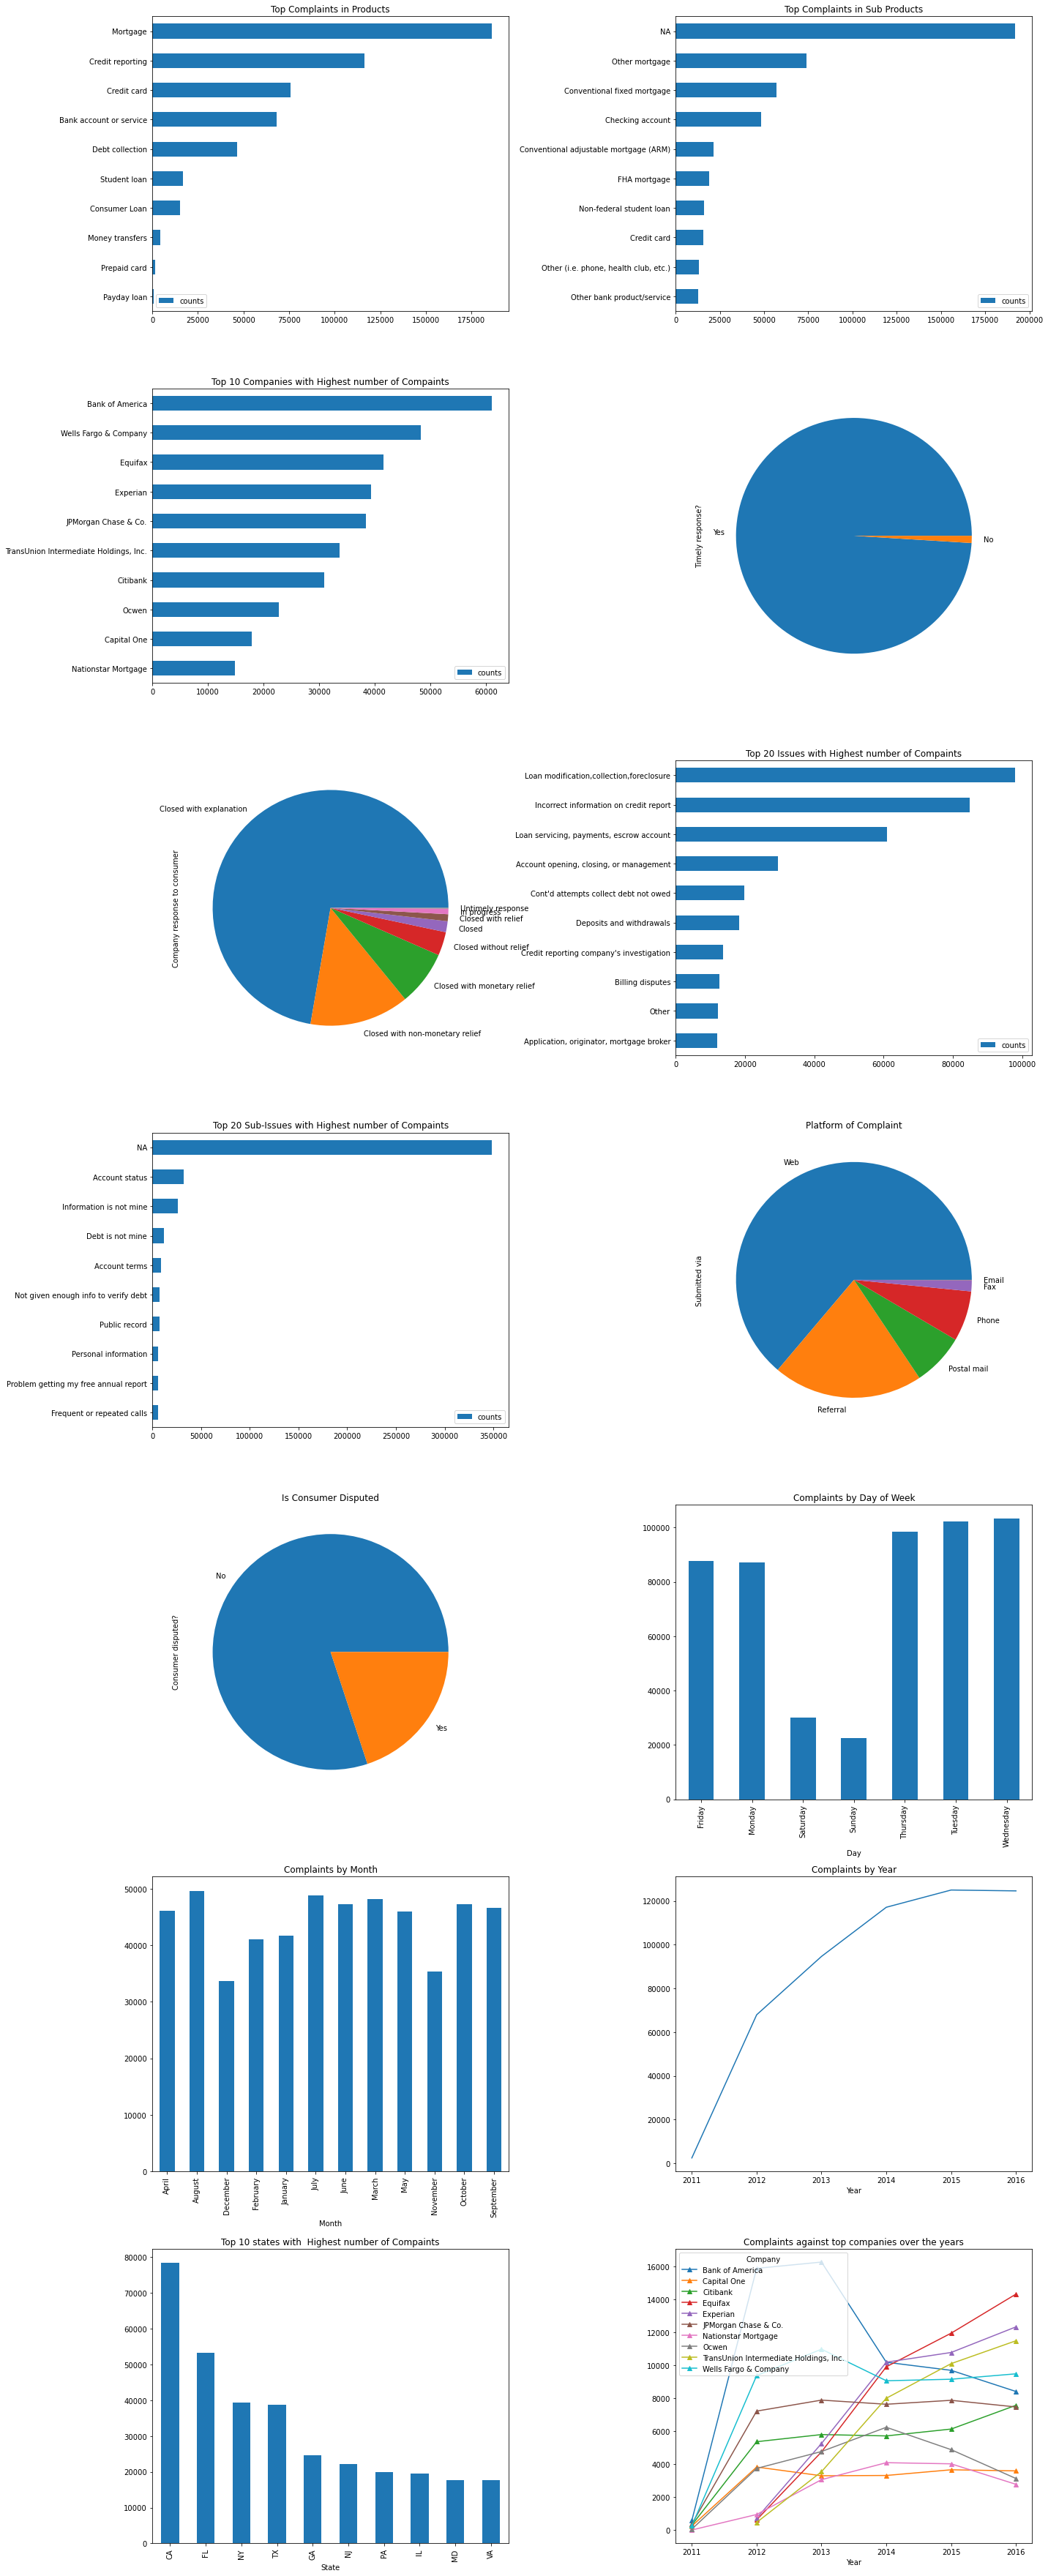

In [20]:
h, w = 7, 2
_, ax=plt.subplots(h,w, figsize=(w*10,h*7))

top_n = 10

df['Product'].value_counts().sort_values(ascending=False)[:top_n].to_frame('counts').sort_values(
            'counts', ascending=True).plot.barh(title='Top Complaints in Products', ax=ax[0][0])
    
df['Sub-product'].value_counts().sort_values(ascending=False)[:top_n].to_frame('counts').sort_values(
            'counts', ascending=True).plot.barh(title='Top Complaints in Sub Products', ax=ax[0][1])
    
df['Company'].value_counts().sort_values(ascending=False)[:top_n].to_frame('counts').sort_values(
            'counts', ascending=True).plot.barh(title='Top 10 Companies with Highest number of Compaints', ax=ax[1][0])
                                                         

df['Timely response?'].value_counts().plot.pie(ax=ax[1][1])

df['Company response to consumer'].fillna('NA').value_counts().plot.pie(ax=ax[2][0])

df['Issue'].value_counts().sort_values(ascending=False)[:top_n].to_frame('counts').sort_values(
            'counts', ascending=True).plot.barh(title='Top 20 Issues with Highest number of Compaints', ax=ax[2][1])
    
df['Sub-issue'].value_counts().sort_values(ascending=False)[:top_n].to_frame('counts').sort_values(
            'counts', ascending=True).plot.barh(title='Top 20 Sub-Issues with Highest number of Compaints', ax=ax[3][0])
                                                         
    
df['Submitted via'].value_counts().plot.pie(title="Platform of Complaint", legend=False, ax=ax[3][1])

df['Consumer disputed?'].value_counts().plot.pie(title="Is Consumer Disputed", legend=False, ax=ax[4][0])

df.groupby(['Day']).size().plot.bar(title="Complaints by Day of Week", legend=False, ax=ax[4][1])

df.groupby(['Month']).size().plot.bar(title="Complaints by Month", legend=False, ax=ax[5][0])

df.groupby(['Year']).size().plot(title="Complaints by Year", legend=False, ax=ax[5][1])

df.groupby(['State']).size().sort_values(ascending=False)[:top_n].plot.bar(
            title="Top 10 states with  Highest number of Compaints", legend=False, ax=ax[6][0])

top_companies=df['Company'].value_counts().sort_values(ascending=False)[:top_n].index

df[df['Company'].isin(top_companies)].groupby(['Year', 'Company']).size().unstack().plot(
            ax=ax[6][1], marker='^', title='Complaints against top companies over the years')


plt.tight_layout()

## Model building and Evaluation

### Feature Selection
Out of the features available, we can drop <b>Date received</b> and <b>Date sent to company</b> since it has no relevance for model building.</br></br>
<b>Year</b> can be dropped since it cannot be used as a categorical feature for clustering</br></br>
Therefore, selected features are <b> Product, 	Sub-product, 	Issue, 	Sub-issue, 	Company, 	State, 		Submitted via, 	Company response to consumer, 	Timely response?, 	Consumer disputed?, Month, 	Day</b>

In [21]:
selected_features = ['Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Company', 'State', 'Submitted via',
       'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Month', 'Day']

### Applying one-hot encoding to the selected categorical features
Using one-hot encoding, we create a new set of dummy (binary) variables that is equal to the number of categories (k) in the categorical feature.</br>
The dummy (binary) variable will just take the value 0 or 1 to indicate the exclusion or inclusion of a category.</br>
This way, we have a separate column for each unique value of a categorical feature.</br>

In [22]:
ohe_df = pd.get_dummies(df[selected_features], drop_first=False)

In [23]:
ohe_df.head()

,Product_Bank account or service,Product_Consumer Loan,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Money transfers,Product_Mortgage,Product_Other financial service,Product_Payday loan,Product_Prepaid card,...,Month_November,Month_October,Month_September,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Implementation of clustering algorithms

We have applied various clustering methods on the given dataset to analyse and compare their performance

- for <b>partitioning method</b> we have used <b>k-means</b> clustering
- for <b>hierarchical method</b> we have tried using <b>agglomerative</b> clustering. But we observed that its not well suited
forlarge datasets due to high space consumption and gives MemoryError
- for <b>density-based method</b> we have tried usingg <b>DBSCAN</b>. But we observed that its not well suited
forlarge datasets due to high space consumption and gives MemoryError

#### Based on the above, we have concluded that K-means clustering is the best clustering algorithm for the given dataset

### Implementing K-Means clustering

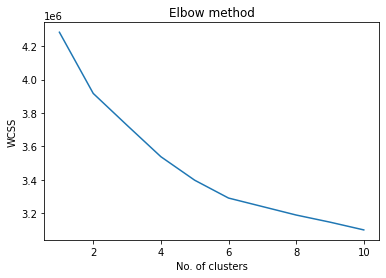

In [25]:
# Finding optimal no. of clusters using Elbow method
wcss = []       # within cluster sum of squares
for num_cluster in range(1,11):
    kmeans = KMeans(n_clusters = num_cluster, init = 'k-means++', random_state = 41)
    kmeans.fit(ohe_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.xlabel('No. of clusters')
plt.ylabel('WCSS')
plt.title('Elbow method')
plt.show()

#### We can see a bend when no of clusters is 6, so we can consider 6 as the optimal number of clusters

In [24]:
model_k=KMeans(n_clusters=6, init = 'k-means++', random_state = 41)
kmeans=model_k.fit(ohe_df)

<AxesSubplot:title={'center':'Distribution of cases by cluster'}, ylabel='clusters_kmeans'>

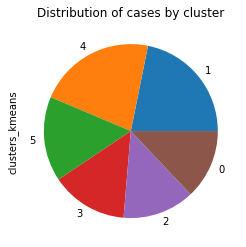

In [27]:
#checking distribution of cases by cluster
df['clusters_kmeans']=kmeans.labels_
df.clusters_kmeans.value_counts().plot.pie(title="Distribution of cases by cluster")

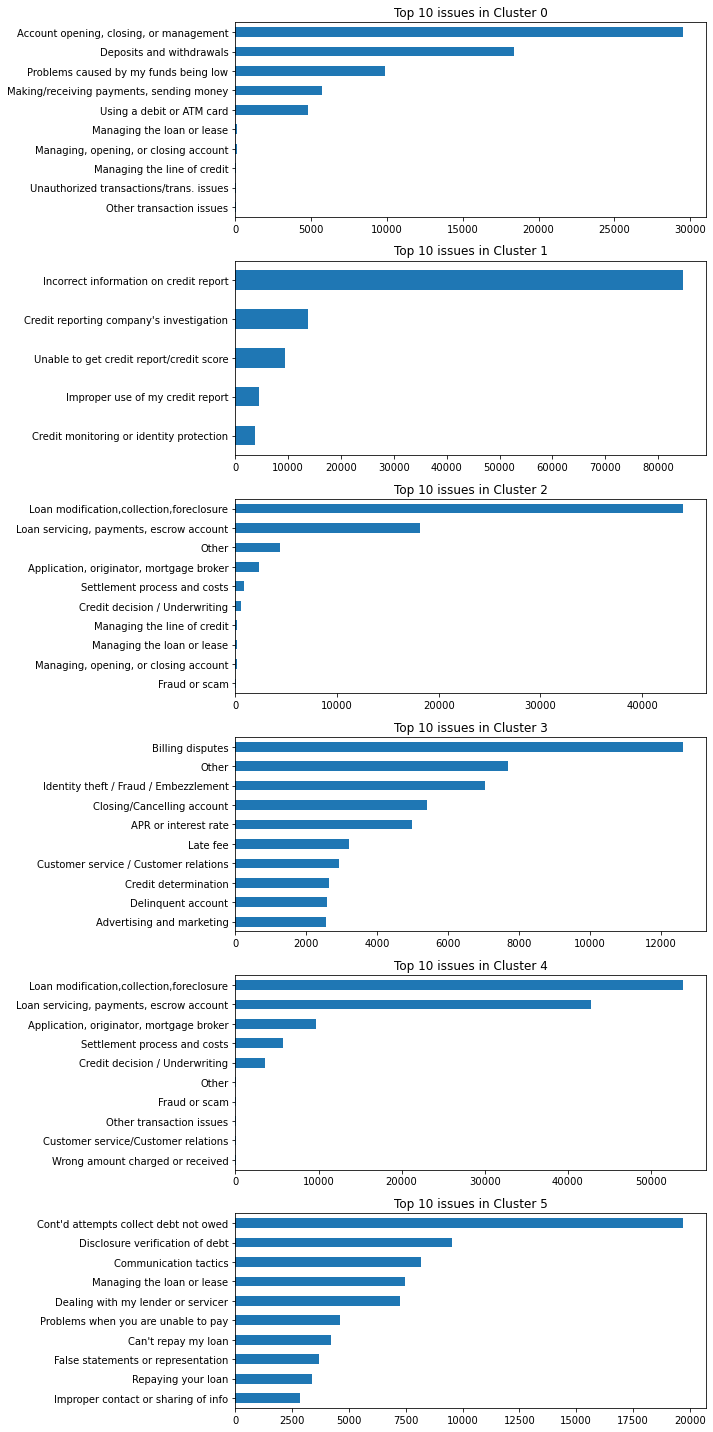

In [33]:
# Analysing top 10 issues within each cluster
_, ax=plt.subplots(kmeans.n_clusters, figsize=(10,20))
n=10
for i in range(kmeans.n_clusters):
    df[df['clusters_kmeans']==i].Issue.value_counts()[:n].sort_values().plot.barh(ax=ax[i],
                                                                           title=f'Top 10 issues in Cluster {i}')    
plt.tight_layout()

#### Observations:

- We can see the cluster 1 has only 5 types of issues, whereas others clusters have 10 or more
- Top issues are not repeating across clusters. This means that the distribution of issues among clusters is good

## Evaluating model performance using cohesion and separation

A well formed set of clusters should have the following set of attributes

- the observations within a cluster should be as close as possible. This is referred to as <b>Cohesion</b>
- the observations from two clusters should be far from each other. This is referred to as <b>Separation</b>

So, for cohesion, lower value is desirable, whereas for separation higher value is desirable

### To Caculate cohesion of a cluster, we need to calculate the average distances of points to the centroid

In [36]:
distances=[]
for i, (vector, label) in enumerate(zip(ohe_df.values, kmeans.labels_)):
    distances+=[{"cluster":label, "distance":np.linalg.norm(vector - kmeans.cluster_centers_[label])}]
    
    
dist_df=pd.DataFrame().from_records(distances)

agg_coh_df = dist_df.groupby('cluster').agg({"distance":["min", "max", "std", "mean"]})
agg_coh_df

distance                              
              min       max       std      mean
cluster                                        
0        2.103855  3.529900  0.190573  2.505508
1        2.020091  3.303817  0.214600  2.393375
2        1.840690  3.558366  0.275131  2.296911
3        2.092530  3.282689  0.164877  2.434894
4        2.020577  3.424787  0.209638  2.407958
5        2.455042  3.715670  0.178318  2.834180

#### Calcluate the average of mean distances of all clusters to get cohesion of the clustering algorithm

In [40]:
print(f'Cohesion using k-means clustering: {np.round(agg_coh_df["distance"]["mean"].mean(),2)}')

Cohesion using k-means clustering: 2.48


### To Caculate separation of a cluster, we need to calculate the average distances of the cluster centriod to the centriod of other clusters

In [60]:
distances=[]
for i, cluster_center in enumerate(kmeans.cluster_centers_):    
    other_centres = np.delete(kmeans.cluster_centers_, i, axis=0)    
    for other_center in other_centres:
        distances+=[{"cluster":i, "distance":np.linalg.norm(cluster_center - other_center)}]
    
    
dist_df=pd.DataFrame().from_records(distances)

agg_sep_df = dist_df.groupby('cluster').agg({"distance":["min", "max", "std", "mean"]})
agg_sep_df


distance                              
              min       max       std      mean
cluster                                        
0        1.847252  2.494198  0.246930  2.093647
1        1.950453  2.748448  0.323196  2.341924
2        1.555540  2.748448  0.427984  2.189036
3        1.882285  2.315305  0.160090  2.059443
4        1.555540  2.434507  0.327322  1.946856
5        1.764015  2.186578  0.160351  1.926117

#### Calcluate the average of mean distances of all clusters to get separation of the clustering algorithm

In [61]:
print(f'Separation using k-means clustering: {np.round(agg_sep_df["distance"]["mean"].mean(),2)}')

Separation using k-means clustering: 2.09


### Calculation of silhoutte score
The silhouette score is a popular measure for evaluating clustering performance. This uses the concept of both cohesion and separation.
For a cluster, the Silhouette score needs to be calculated for all the points in a cluster and an average is taken. The value lies between -1 and 1, higher the value better is the cluster.

In [37]:
print(f'Silhouette_score using k-means clustering: {silhouette_score(ohe_df.values, kmeans.labels_).round(2)}')

Silhouette_score using k-means clustering: 0.1


## Summary

- A positive silhouette score indicates that clusters are well formed.
- Analysis of top issues in all clusters indicate that the distribution of issues among clusters is good
- But silhouette value being close to zero, and very close cohesion and separation values suggest that there can be some overlapping, and the model can be improved


## Suggested ways of Improvement
- For k-means algorithm, <b>initialization</b> can be the key to the performance
- If the center with the maximum distance gets initially chosen, we can easily select an outlier as the center.
- To alleviate this, we can try initializing the centers multiple times and select the initialization that has the lowest inertia
- More sophisticated initialization techniques can also the tried like <b>Partitioning Around Medoids</b>